In [3]:
import pandas as pd
import numpy as np
from time import time, sleep
import datetime
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import tree, svm, ensemble, cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score , f1_score , roc_auc_score, fbeta_score, make_scorer

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

This Project is based on a supervised learning model to predict and find out why a patient doesn't show on their appointments. Every year there are many patients that don't show on their appointments. This wastes a lot of time and money for both patients and healthcare services. Hopefully this model will help both Healthcare services and Patients to learn strategies which can save them time and money.

### Importing Data

In [2]:
# We importing data in a pandas library with read_csv

df = pd.read_csv("data/KaggleV2-May-2016.csv")
pd.options.display.max_columns = 999 #Set maximum number of display columns to 999
len(df)

110527

### Missing Values

In [4]:
metadata=df.columns
for i in metadata:
    print("There are %d missing vlalues in column %s" % (sum(df.isnull()[i]), i))

There are 0 missing vlalues in column PatientId
There are 0 missing vlalues in column AppointmentID
There are 0 missing vlalues in column Gender
There are 0 missing vlalues in column ScheduledDay
There are 0 missing vlalues in column AppointmentDay
There are 0 missing vlalues in column Age
There are 0 missing vlalues in column Neighbourhood
There are 0 missing vlalues in column Scholarship
There are 0 missing vlalues in column Hipertension
There are 0 missing vlalues in column Diabetes
There are 0 missing vlalues in column Alcoholism
There are 0 missing vlalues in column Handcap
There are 0 missing vlalues in column SMS_received
There are 0 missing vlalues in column No-show


### Data Preparation

##### Here we prepare data with different techninques to make our analysis more efficient and robust

We use Sheduledday variable to decomponent scheduled weekday and scheduled hour. We want to analyse if some weekdays or hours have more effect on not showing of patient

In [5]:
# We use Sheduledday variable to decomponent scheduled weekday and scheduled hour. We want to analyse if some weekdays or hours have more effect on not showing of patient

Scheduled_weekday = []
Scheduled_hour = []

for i in df["ScheduledDay"]:
    date_temp , time_temp = i.split('T')
    time_temp=time_temp[:-1]
    year, month, day = (int(x) for x in date_temp.split('-'))
    weekday = datetime.date(year, month, day).weekday()
    
    hour, minute, second  = (int(x) for x in time_temp.split(':'))
    
    Scheduled_weekday.append(weekday)
    Scheduled_hour.append(hour)
df["Scheduled_weekday"] = Scheduled_weekday
df["Scheduled_hour"] = Scheduled_hour


#### We define Target which is No-Show column and Features which is all other columns. We will use features to make a model which can predict our target.

In [6]:
target = (df["No-show"] == "Yes").astype(int)
#features = df.drop(["No-show","Neighbourhood","ScheduledDay","AppointmentDay","PatientId","AppointmentID"],axis=1)
features = df.drop(["No-show","ScheduledDay","AppointmentDay","PatientId","AppointmentID"],axis=1)

### Benchmark

In [7]:
N=len(features)

prediction = pd.DataFrame(0, index=np.arange(N), columns=["prediction"])

for i in range(N):
    if( (features["Hipertension"][i] == 1) or (features["Alcoholism"][i] == 1) or (features["Handcap"][i] == 1) or (features["Diabetes"][i] == 1)):

        prediction["prediction"][i] = 1
        
accuracy_score(prediction["prediction"],target)


0.64513648248844169

### One-Hot encoding
We use pandas library get_dummies to get One hot encoding of our data. One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.
Most complicated category for onehot encoding is neighboarhood. It has 81 ditinct values which will be added to number of columns of feature_encoded afte one-hot encoding


In [8]:
features_encoded = pd.get_dummies(features);

In [9]:
features.head() #Helps us get feeling of our data

Gender  Age      Neighbourhood  Scholarship  Hipertension  Diabetes  \
0      F   62    JARDIM DA PENHA            0             1         0   
1      M   56    JARDIM DA PENHA            0             0         0   
2      F   62      MATA DA PRAIA            0             0         0   
3      F    8  PONTAL DE CAMBURI            0             0         0   
4      F   56    JARDIM DA PENHA            0             1         1   

   Alcoholism  Handcap  SMS_received  Scheduled_weekday  Scheduled_hour  
0           0        0             0                  4              18  
1           0        0             0                  4              16  
2           0        0             0                  4              16  
3           0        0             0                  4              17  
4           0        0             0                  4              16

In [10]:
features_encoded.head() #Helps us get feeling of encoded data

Age  Scholarship  Hipertension  Diabetes  Alcoholism  Handcap  \
0   62            0             1         0           0        0   
1   56            0             0         0           0        0   
2   62            0             0         0           0        0   
3    8            0             0         0           0        0   
4   56            0             1         1           0        0   

   SMS_received  Scheduled_weekday  Scheduled_hour  Gender_F  Gender_M  \
0             0                  4              18         1         0   
1             0                  4              16         0         1   
2             0                  4              16         1         0   
3             0                  4              17         1         0   
4             0                  4              16         1         0   

   Neighbourhood_AEROPORTO  Neighbourhood_ANDORINHAS  \
0                        0                         0   
1                        0                         0   
2                        0                         0   
3                        0                         0   
4                        0                         0   

   Neighbourhood_ANTÔNIO HONÓRIO  Neighbourhood_ARIOVALDO FAVALESSA  \
0                              0                                  0   
1                              0                                  0   
2                              0                                  0   
3                              0                                  0   
4                              0                                  0   

   Neighbourhood_BARRO VERMELHO  Neighbourhood_BELA VISTA  \
0                             0                         0   
1                             0                         0   
2                             0                         0   
3                             0                         0   
4                             0                         0   

   Neighbourhood_BENTO FERREIRA  Neighbourhood_BOA VISTA  \
0                             0                        0   
1                             0                        0   
2                             0                        0   
3                             0                        0   
4                             0                        0   

   Neighbourhood_BONFIM  Neighbourhood_CARATOÍRA  Neighbourhood_CENTRO  \
0                     0                        0                     0   
1                     0                        0                     0   
2                     0                        0                     0   
3                     0                        0                     0   
4                     0                        0                     0   

   Neighbourhood_COMDUSA  Neighbourhood_CONQUISTA  Neighbourhood_CONSOLAÇÃO  \
0                      0                        0                         0   
1                      0                        0                         0   
2                      0                        0                         0   
3                      0                        0                         0   
4                      0                        0                         0   

   Neighbourhood_CRUZAMENTO  Neighbourhood_DA PENHA  Neighbourhood_DE LOURDES  \
0                         0                       0                         0   
1                         0                       0                         0   
2                         0                       0                         0   
3                         0                       0                         0   
4                         0                       0                         0   

   Neighbourhood_DO CABRAL  Neighbourhood_DO MOSCOSO  Neighbourhood_DO QUADRO  \
0                        0                         0                        0   
1                        0                         0                        0   
2      

In [11]:
print("There are %d number of columns in features" % len(features.columns))
print("There are %d number of columns in features_encoded" % len(features_encoded.columns))

There are 11 number of columns in features
There are 92 number of columns in features_encoded


### Outliers

In [12]:
Neighbourhood=features_encoded.columns[11:]
for i in Neighbourhood:
    if(sum(features_encoded[i]) < 10):
        print("This Neighberhood with %d observations can be counted as an outlier: %s" %(sum(features_encoded[i]),i))
        features_encoded=features_encoded.drop([i], axis=1)


This Neighberhood with 8 observations can be counted as an outlier: Neighbourhood_AEROPORTO
This Neighberhood with 2 observations can be counted as an outlier: Neighbourhood_ILHAS OCEÂNICAS DE TRINDADE
This Neighberhood with 1 observations can be counted as an outlier: Neighbourhood_PARQUE INDUSTRIAL


In [13]:
Age = Counter(features_encoded["Age"])
labels, values = zip(*Counter(features_encoded["Age"]).items())

for i,j in zip(labels,values):
    if(j<10):
        print("In age %d there is only %d observations"%(i,j))
        df = df.drop(df.index[df['Age'] == i].tolist())
        features_encoded = features_encoded.drop(features_encoded.index[features_encoded['Age'] == i].tolist())

In age 98 there is only 6 observations
In age 102 there is only 2 observations
In age 115 there is only 5 observations
In age 100 there is only 4 observations
In age 99 there is only 1 observations
In age -1 there is only 1 observations


### Exploring Data

In [19]:
alist = ['Age','Scheduled_weekday','Scheduled_hour']

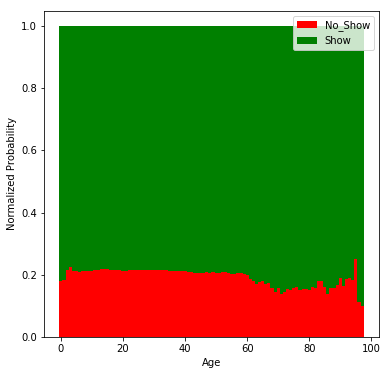

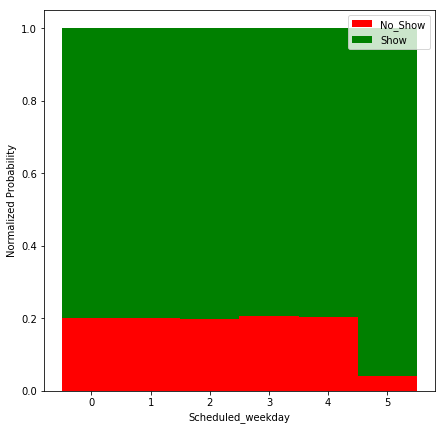

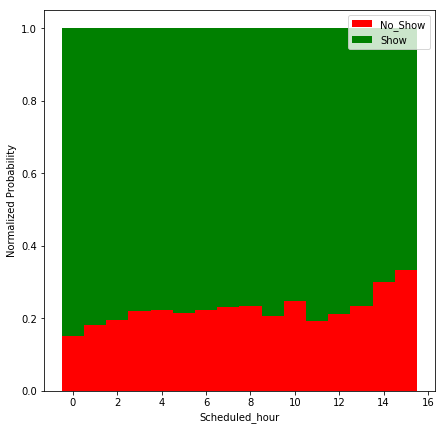

In [20]:
for s in alist:
    labels1, values1 = zip(*Counter(features_encoded[s]).most_common())
    labels2, values2 = zip(*Counter(features_encoded_show[s]).most_common())

    value_1=[0]*len(labels1)
    value_2=[0]*len(labels1)

    for i in range(len(labels1)):
        value_1[i] = values1[i]/(values1[i]+values2[i])
        value_2[i] = values2[i]/(values1[i]+values2[i])
        #a[i]=1
        #print(a)
    indexes = np.arange(len(labels1))
    p1 = plt.bar(indexes, value_1, 1, color='red')
    p2 = plt.bar(indexes, value_2, 1, color='green', bottom=value_1)

    plt.xlabel(s)
    plt.ylabel("Normalized Probability")
    plt.legend((p1[0], p2[0]), ('No_Show', 'Show'))


    plt.rcParams["figure.figsize"] = [7,7]
    plt.show()

In [21]:
alist = ['Scholarship','Hipertension','Diabetes','Alcoholism','Handcap','SMS_received','Gender_F','Gender_M']

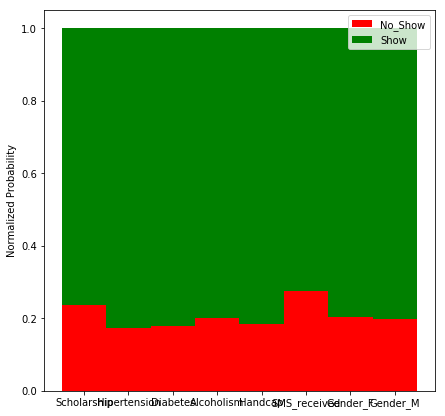

In [22]:
values_no_show = [0]*len(alist)
values_show = [0]*len(alist)
indexes=list(range(0,len(alist)))
for i in range(len(alist)):
    values_no_show[i] = sum(features_encoded[alist[i]]) /(sum(features_encoded[alist[i]])+sum(features_encoded_show[alist[i]]))
    values_show[i] = sum(features_encoded_show[alist[i]])/(sum(features_encoded[alist[i]])+sum(features_encoded_show[alist[i]]))

#indexes = np.arange(len(labels1))
p1 = plt.bar(indexes, values_no_show, 1, color='red')
p2 = plt.bar(indexes, values_show, 1, color='green', bottom=values_no_show)

plt.legend((p1[0], p2[0]), ('No_Show', 'Show'))
plt.ylabel("Normalized Probability")
plt.xticks(list(range(len(alist))), alist)
plt.rcParams["figure.figsize"] = [10,10]
plt.show()

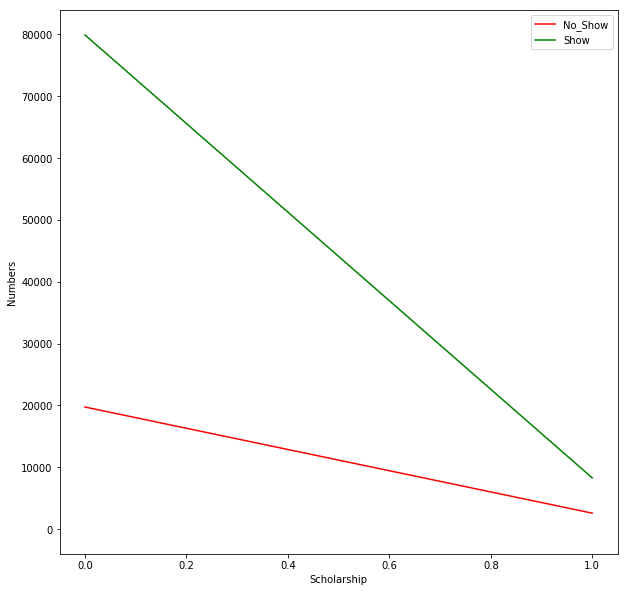

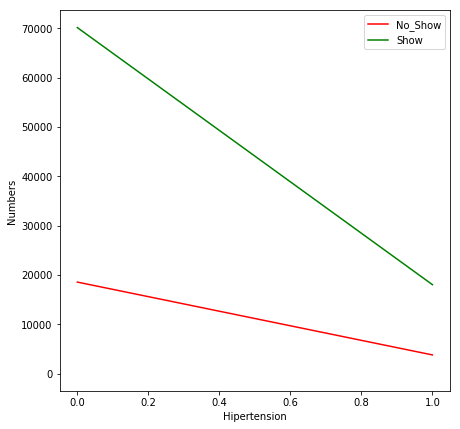

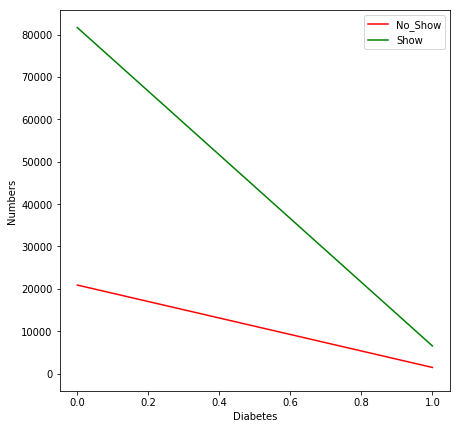

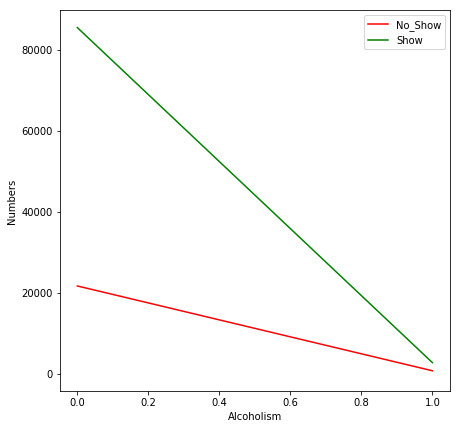

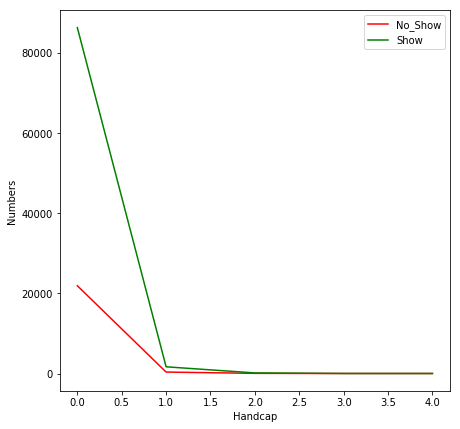

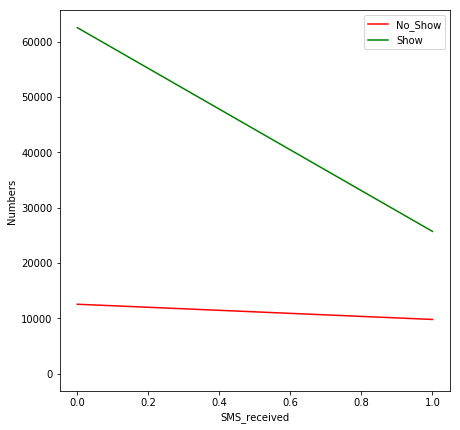

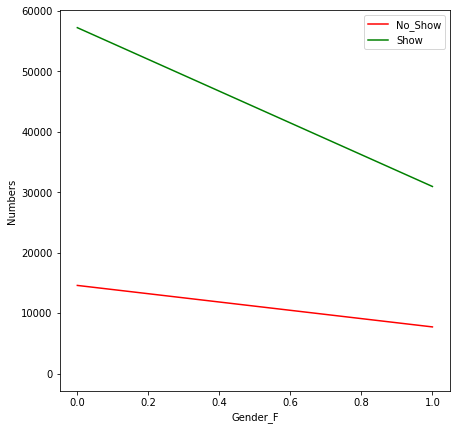

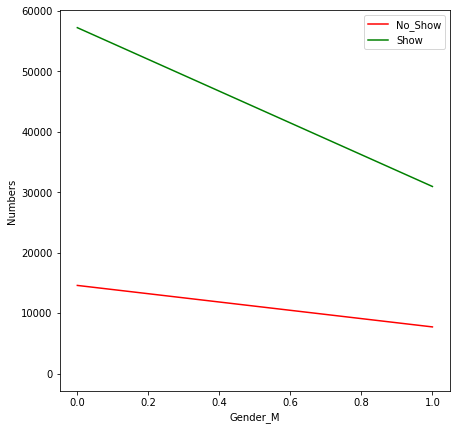

In [23]:
for s in alist:
    labels1, values1 = zip(*Counter(features_encoded[s]).most_common())
    labels2, values2 = zip(*Counter(features_encoded_show[s]).most_common())

    value_1=[0]*len(labels1)
    value_2=[0]*len(labels1)

    for i in range(len(labels1)):
        value_1[i] = values1[i]#/(values1[i]+values2[i])
        value_2[i] = values2[i]#/(values1[i]+values2[i])
        #a[i]=1
        #print(a)
    indexes = np.arange(len(labels1))
    p1 = plt.plot(indexes, value_1, 1, color='red')
    p2 = plt.plot(indexes, value_2, 1, color='green')

    plt.xlabel(s)
    plt.ylabel("Numbers")
    plt.legend((p1[0], p2[0]), ('No_Show', 'Show'))


    plt.rcParams["figure.figsize"] = [7,7]
    plt.show()

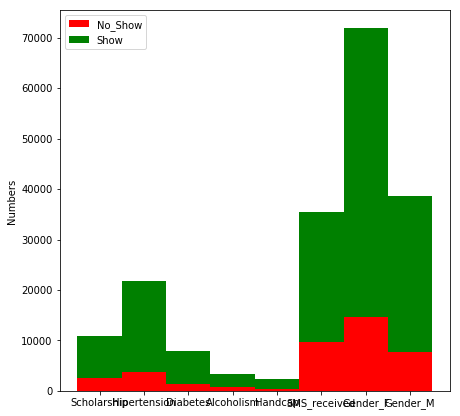

In [24]:
values_no_show = [0]*len(alist)
values_show = [0]*len(alist)
indexes=list(range(0,len(alist)))
for i in range(len(alist)):
    values_no_show[i] = sum(features_encoded[alist[i]])# /(sum(features_encoded[alist[i]])+sum(features_encoded_show[alist[i]]))
    values_show[i] = sum(features_encoded_show[alist[i]])#/(sum(features_encoded[alist[i]])+sum(features_encoded_show[alist[i]]))

#indexes = np.arange(len(labels1))
p1 = plt.bar(indexes, values_no_show, 1, color='red')
p2 = plt.bar(indexes, values_show, 1, color='green', bottom=values_no_show)

plt.legend((p1[0], p2[0]), ('No_Show', 'Show'))
plt.ylabel("Numbers")
plt.xticks(list(range(len(alist))), alist)
plt.rcParams["figure.figsize"] = [10,10]
plt.show()

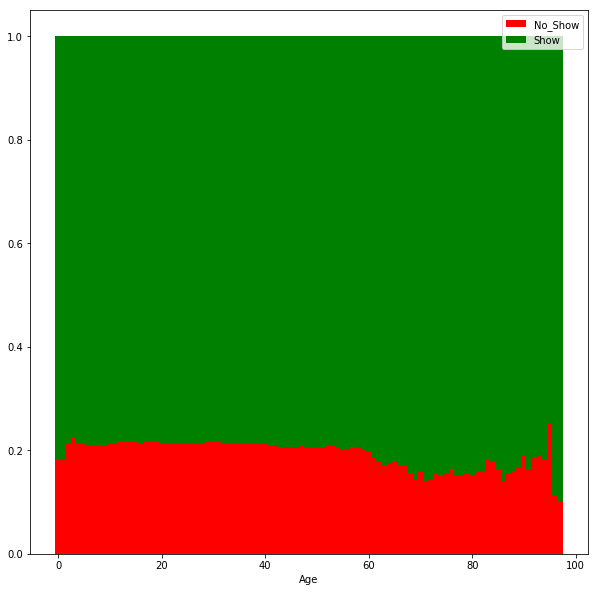

In [25]:
labels1, values1 = zip(*Counter(features_encoded["Age"]).most_common())
labels2, values2 = zip(*Counter(features_encoded_show["Age"]).most_common())

value_1=[0]*len(labels1)
value_2=[0]*len(labels1)

for i in range(len(labels1)):
    value_1[i] = values1[i]/(values1[i]+values2[i])
    value_2[i] = values2[i]/(values1[i]+values2[i])
    #a[i]=1
    #print(a)
indexes = np.arange(len(labels1))
p1 = plt.bar(indexes, value_1, 1, color='red')
p2 = plt.bar(indexes, value_2, 1, color='green', bottom=value_1)

plt.xlabel('Age')
plt.legend((p1[0], p2[0]), ('No_Show', 'Show'))


plt.rcParams["figure.figsize"] = [10,10]
plt.show()

#### Probability of showing and not showing distributed in age

In [26]:
ts = df.copy()
ts["No-show"] = (ts["No-show"] == "Yes").astype(int)
ts=ts[ts["No-show"]==1]

target = ts["No-show"]

features = ts.drop(["No-show","Neighbourhood","ScheduledDay","AppointmentDay","PatientId","AppointmentID"],axis=1)
features_encoded = pd.get_dummies(features);

In [27]:
ts_show = df.copy()
ts_show["No-show"] = (ts_show["No-show"] == "Yes").astype(int)
ts_show = ts_show[ts_show["No-show"]==0]

target_show = ts_show ["No-show"]
features_show = ts_show.drop(["No-show","Neighbourhood","ScheduledDay","AppointmentDay","PatientId","AppointmentID"],axis=1)
features_encoded_show = pd.get_dummies(features_show);

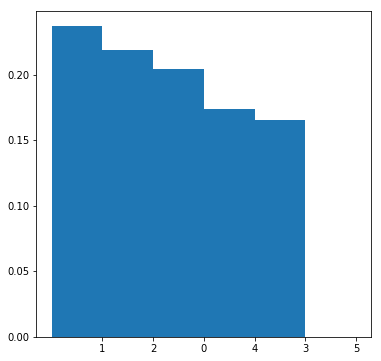

In [28]:
labels, values = zip(*Counter(ts["Scheduled_weekday"]).most_common())
values = tuple(map(lambda x: x/sum(values), values))
indexes = np.arange(len(labels))
width = 1
plt.rcParams["figure.figsize"] = [6,6]
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

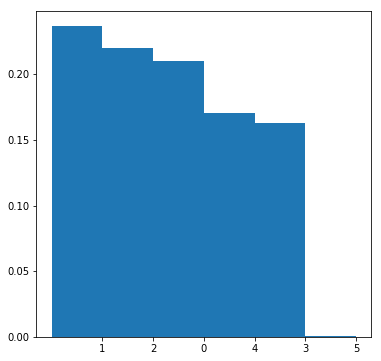

In [29]:
labels, values = zip(*Counter(ts_show["Scheduled_weekday"]).most_common())
values = tuple(map(lambda x: x/sum(values), values))
indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

In [30]:
F=sum(features["Gender"]=="F")
M=sum(features["Gender"]=="M")
F_show=sum(features_show["Gender"]=="F")
M_show=sum(features_show["Gender"]=="M")
N=len(features)
N_show=len(features_show)

print("-------STAT-------\n")
print("%.1f %% of patients did not show on their appointments\n"% (100*len(ts)/len(df)))

print("%.1f %% Men %.1f percent Women didnt show on their appointment" % (100*M/N,100*F/N))
print("%.1f %% Men %.1f percent Women showed on their appointment\n" % (100*M_show/N_show,100*F_show/N_show))

print("%.1f %% of those did not show had scholarship" % (100*sum(ts["Scholarship"])/N ))
print("%.1f %% of those show had scholarship\n" % (100*sum(ts_show["Scholarship"])/N_show ))

print("%.1f %% of those did not show was Hipertension" % (100*sum(ts["Hipertension"])/N ))
print("%.1f %% of those show was Hipertension\n" % (100*sum(ts_show["Hipertension"])/N_show ))

print("%.1f %% of those did not show was Diabetes" % (100*sum(ts["Diabetes"])/N ))
print("%.1f %% of those show was Diabetes\n" % (100*sum(ts_show["Diabetes"])/N_show ))

print("%.1f %% of those did not show was Alcoholism" % (100*sum(ts["Alcoholism"])/N ))
print("%.1f %% of those show was Alcoholism\n" % (100*sum(ts_show["Alcoholism"])/N_show ))

print("%.1f %% of those did not show was Handcap" % (100*sum(ts["Handcap"])/N ))
print("%.1f %% of those show was Handcap\n" % (100*sum(ts_show["Handcap"])/N_show ))

print("%.1f %% of those did not show was received SMS" % (100*sum(ts["SMS_received"])/N ))
print("%.1f %% of those show was received SMS\n" % (100*sum(ts_show["SMS_received"])/N_show ))

-------STAT-------

20.2 % of patients did not show on their appointments

34.6 % Men 65.4 percent Women didnt show on their appointment
35.1 % Men 64.9 percent Women showed on their appointment

11.6 % of those did not show had scholarship
9.4 % of those show had scholarship

16.9 % of those did not show was Hipertension
20.4 % of those show was Hipertension

6.4 % of those did not show was Diabetes
7.4 % of those show was Diabetes

3.0 % of those did not show was Alcoholism
3.0 % of those show was Alcoholism

2.0 % of those did not show was Handcap
2.3 % of those show was Handcap

43.8 % of those did not show was received SMS
29.1 % of those show was received SMS



### Split Data to Test and Training set

In [12]:

# Spliting the 'features' and 'target' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_encoded, target, test_size = 0.2, random_state = 27)



# Show the results of the split
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 88421 samples.
Testing set has 22106 samples.


In [13]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    #define scorer
    roc_score = make_scorer(roc_auc_score)
    
    results = {}
    
    #Fit the learner to the training data 
    start = time() # Get start time
    learner = learner.fit(X_train, y_train)
    end = time() # Get end time
    
    #Calculate the training time
    results['train_time'] = end-start
        
    #Get the predictions on the test set
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    #Calculate the total prediction time
    results['pred_time'] = end-start
            
    results['roc_acc_test'] = roc_auc_score(y_train, predictions_train)
    results['roc_acc_train'] = roc_auc_score(y_test, predictions_test)
    results['acc_test'] = accuracy_score(y_train, predictions_train)
    results['acc_train'] = accuracy_score(y_test, predictions_test)
    
    # Success
    print ("{} trained on {} samples.".format(learner.__class__.__name__, n_records))

    
        
    # Return the results
    return results

Testing different models to check which gives best accuracy

In [14]:
N=len(df)

n_records = N
samples_100 = n_records

# Initialize the four models
clf_A = tree.DecisionTreeClassifier()
clf_B = GaussianNB()
clf_C = ensemble.GradientBoostingClassifier()
clf_D = XGBClassifier()




# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_100]):#[samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, X_train, y_train, X_test, y_test)


results

DecisionTreeClassifier trained on 110527 samples.
GaussianNB trained on 110527 samples.
GradientBoostingClassifier trained on 110527 samples.
XGBClassifier trained on 110527 samples.


{'DecisionTreeClassifier': {0: {'acc_test': 0.97501724703407566,
   'acc_train': 0.71084773364697362,
   'pred_time': 0.08487415313720703,
   'roc_acc_test': 0.94098191736142733,
   'roc_acc_train': 0.54349737764425898,
   'train_time': 1.338679313659668}},
 'GaussianNB': {0: {'acc_test': 0.62349441874667788,
   'acc_train': 0.61530806115986614,
   'pred_time': 0.2097606658935547,
   'roc_acc_test': 0.54570289700007257,
   'roc_acc_train': 0.53573411316378905,
   'train_time': 0.1970195770263672}},
 'GradientBoostingClassifier': {0: {'acc_test': 0.79845285622193818,
   'acc_train': 0.7973400886637112,
   'pred_time': 0.3621838092803955,
   'roc_acc_test': 0.50074897727381196,
   'roc_acc_train': 0.50010985811378683,
   'train_time': 18.90012550354004}},
 'XGBClassifier': {0: {'acc_test': 0.79828321326381746,
   'acc_train': 0.79743056183841488,
   'pred_time': 0.3839735984802246,
   'roc_acc_test': 0.50028671490010246,
   'roc_acc_train': 0.5001665860466209,
   'train_time': 13.7326478

We use 4 models to compare accuracy. 
1. Decision Tree Classifier
2. Gaussian Naive Base Classifier
3. Gradient Boosting Classifier
4. XGradient Boosting Classifier

We find out that Decision Tree Classifier gives us best accuracy with 54.2% ROC Accuracy on training set.
We use this classifier and try to tune model parameters to gain better accuracy.

### Model Tuning

In [16]:

best_clf = tree.DecisionTreeClassifier()
cv = cross_validation.StratifiedShuffleSplit(y_train, n_iter=10, test_size=0.2, random_state=27)


def Model_Tuning(parameters, clf):
    # Initialize the classifier
    start = time() # Get start time    


    # Make an fbeta_score scoring object
    scorer = make_scorer(roc_auc_score)
    grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer, fit_params=None, n_jobs=24, iid=True, 
                            refit=True, cv=cv, verbose=0, pre_dispatch='2*n_jobs')

    # Fit the grid search object to the training data and find the optimal parameters
    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_
    #print(best_clf)
    # Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)

    best_est = grid_fit.best_params_
    
    print("\Accuracy\n-------------------------------------")
    print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
    
    
    
    print("Best Estimator %s" % best_est)
    
    print("Best Score %s" % grid_fit.best_score_)
    #print("Best Grid Score %s" % grid_fit.grid_scores_)
    
    end = time() # Get end time
    #Calculate the total prediction time
    print("TIME SPEND : %f" % (end-start))
    
    return best_clf

In [17]:

start2 = time() # Get start time
parameters = {
    #'param1' : {'n_estimators':range(100,200,20)},
    'param2' : {'max_depth':range(40,100,5), 'min_samples_split':range(2,3,1)},
    'param3' : {'min_samples_split':range(2,10,2), 'min_samples_leaf':range(2,100,10)},
    'param4' : {'max_features':range(1,60,10)},
    #'param5' : {'subsample':[0.6,0.7,0.75,0.8,0.85,0.99]}
}

#clf = ensemble.GradientBoostingClassifier()
clf = tree.DecisionTreeClassifier()

for param in parameters:
    clf = Model_Tuning(parameters[param],clf)
    print('-------------------------------------')
    print('-------------------------------------')
    



end2 = time() # Get end time
    #Calculate the total prediction time
print("------------------------------------------------")
print("TIME SPEND TOTAL: %f" % (end2-start2))

#Best Estimator {'max_depth': 86, 'min_samples_split': 2}

\Accuracy
-------------------------------------
Final accuracy score on the testing data: 0.7113
Final F-score on the testing data: 0.2741
Best Estimator {'max_depth': 70, 'min_samples_split': 2}
Best Score 0.542679943774
TIME SPEND : 15.376091
-------------------------------------
-------------------------------------
\Accuracy
-------------------------------------
Final accuracy score on the testing data: 0.7185
Final F-score on the testing data: 0.2756
Best Estimator {'max_features': 31}
Best Score 0.544793004117
TIME SPEND : 5.772158
-------------------------------------
-------------------------------------
\Accuracy
-------------------------------------
Final accuracy score on the testing data: 0.7566
Final F-score on the testing data: 0.2480
Best Estimator {'min_samples_leaf': 2, 'min_samples_split': 2}
Best Score 0.531220401705
TIME SPEND : 16.860768
-------------------------------------
-------------------------------------
------------------------------------------------
TIME

Model Tuning can help us gain better accuracy. We can notice by choosing maxdepth = 51 accuracy can increase from 54.2% to 54.6%
Its not a lot in this case but parameter optimization is a very important part in model optimizaiton to avoid over complexity or under simplicity. 

### Feature Importance

In [51]:
# Train the supervised model on the training set 
model = best_clf.fit(X_train, y_train) 

# Extract the feature importances
importances = model.feature_importances_

In [52]:
important_features = pd.concat([pd.DataFrame(X_train.columns,columns=['feat']) , pd.DataFrame(importances,columns=['importance'])], axis=1)
important_features.sort_values('importance',ascending=False)



feat  importance
0                                         Age    0.288453
7                           Scheduled_weekday    0.150780
8                              Scheduled_hour    0.144508
10                                   Gender_M    0.030987
9                                    Gender_F    0.030824
2                                Hipertension    0.020280
1                                 Scholarship    0.018098
6                                SMS_received    0.017444
3                                    Diabetes    0.012992
49               Neighbourhood_JARDIM CAMBURI    0.010439
19                       Neighbourhood_BONFIM    0.007885
50              Neighbourhood_JARDIM DA PENHA    0.007774
77                 Neighbourhood_SANTA MARTHA    0.007626
4                                  Alcoholism    0.007261
5                                     Handcap    0.007240
89                   Neighbourhood_TABUAZEIRO    0.007026
21                       Neighbourhood_CENTRO    0.006959
70                  Neighbourhood_RESISTÊNCIA    0.006439
48                       Neighbourhood_JABOUR    0.006304
80                Neighbourhood_SANTO ANTÔNIO    0.006009
38                     Neighbourhood_GURIGICA    0.005906
54                  Neighbourhood_MARIA ORTIZ    0.005854
71                        Neighbourhood_ROMÃO    0.005774
79                  Neighbourhood_SANTO ANDRÉ    0.005476
87                     Neighbourhood_SÃO JOSÉ    0.005433
88                    Neighbourhood_SÃO PEDRO    0.005416
86                Neighbourhood_SÃO CRISTÓVÃO    0.005211
26                     Neighbourhood_DA PENHA    0.005205
55                      Neighbourhood_MARUÍPE    0.005151
34               Neighbourhood_FORTE SÃO JOÃO    0.004964
..                                        ...         ...
82                  Neighbourhood_SANTOS REIS    0.002539
29                   Neighbourhood_DO MOSCOSO    0.002499
64                      Neighbourhood_PIEDADE    0.002084
56                Neighbourhood_MATA DA PRAIA    0.002053
32                   Neighbourhood_ESTRELINHA    0.001924
28                    Neighbourhood_DO CABRAL    0.001894
76                  Neighbourhood_SANTA LÚCIA    0.001882
15               Neighbourhood_BARRO VERMELHO    0.001758
75                  Neighbourhood_SANTA LUÍZA    0.001719
27                   Neighbourhood_DE LOURDES    0.001505
84                 Neighbourhood_SOLON BORGES    0.001504
22                      Neighbourhood_COMDUSA    0.001395
13              Neighbourhood_ANTÔNIO HONÓRIO    0.001370
14          Neighbourhood_ARIOVALDO FAVALESSA    0.001291
59               Neighbourhood_MÁRIO CYPRESTE    0.001281
35                    Neighbourhood_FRADINHOS    0.001252
18                    Neighbourhood_BOA VISTA    0.001158
39                        Neighbourhood_HORTO    0.001113
31               Neighbourhood_ENSEADA DO SUÁ    0.001033
74                 Neighbourhood_SANTA HELENA    0.000980
60                     Neighbourhood_NAZARETH    0.000862
90                Neighbourhood_UNIVERSITÁRIO    0.000722
83             Neighbourhood_SEGURANÇA DO LAR    0.000675
58            Neighbourhood_MORADA DE CAMBURI    0.000520
65            Neighbourhood_PONTAL DE CAMBURI    0.000366
42                  Neighbourhood_ILHA DO BOI    0.000152
45  Neighbourhood_ILHAS OCEÂNICAS DE TRINDADE    0.000111
11                    Neighbourhood_AEROPORTO    0.000052
43                Neighbourhood_ILHA DO FRADE    0.000016
62            Neighbourhood_PARQUE INDUSTRIAL    0.000000

[92 rows x 2 columns]

### Feature Selection

In [53]:
# Import functionality for cloning a model
from sklearn.base import clone


best_predictions = best_clf.predict(X_test)

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:20]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:20]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
#print( "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print( "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print( "roc_score on testing data: {:.4f}".format(roc_auc_score(y_test, best_predictions)))
print( "\nFinal Model trained on reduced data\n------")
#print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))
print( "roc_score on testing data: {:.4f}".format(roc_auc_score(y_test, reduced_predictions)))



Final Model trained on full data
------
F-score on testing data: 0.2749
roc_score on testing data: 0.5449

Final Model trained on reduced data
------
F-score on testing data: 0.2318
roc_score on testing data: 0.5216


Feature importance is a very important part of supervised learning. We can notice that by using 20 most important features from 92 features we can reduce data by 72 columns but accuracy decrease only 2%. Its a quite reasonable result for huge datasets. We can save a lot of time and complexity and still hold accuracy up.

We can notice age is most important feature for patient to dont show. We can go deeper into this feature to undrestand it better.